In [1]:
# Import librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from dask import bag, diagnostics
import cv2
import skopt
import plotly_express as px
import scipy.ndimage
import umap


from skimage import io, color, exposure, transform, img_as_float32
import skimage

In [2]:
# Import et affichage des 5 premières lignes du Dataframe
df = pd.read_csv("dataset.csv")
df.head()

img_path   classes sub_classes
0  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...  basophil          BA
1  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...  basophil          BA
2  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...  basophil          BA
3  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...  basophil          BA
4  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...  basophil          BA

In [3]:
df.isna().sum()

img_path       0
classes        0
sub_classes    0
dtype: int64

In [4]:
px.histogram(df.classes, labels={'value': 'Classe de globule blanc', 'variable':"Quantité d'images", 'color': 'classes'},
             text_auto='.3s', color = df.classes)

Acronymes des labels :

- **BA** : **BA**sophiles
- **BNE** : **NE**utrophiles de **B**ande
- **EO** : **EO**sinophiles
- **ERB** : **ER**ythro**B**lastes
- **LY** : **LY**mphocytes
- **MMY** : **M**éta**MY**élocytes
- **MO** : **MO**nocytes
- **MY** : **MY**élocytes
- **PLT** : **PL**aque**T**tes
- **PMY** : **P**ro**MY**élocytes
- **SNE** : **NE**utrophiles **S**egmentés

On remarque que les classes ne sont pas équilibrées, il faudra peut-être avoir recours à de l'augmentation de données.

In [5]:
# Chargement des images et redimensionnement des outliers

def load_image(filename: str,  as_gray: bool = False, rescale: float = None) -> np.ndarray:
    '''
    load images from path
    
    Args:
    - filename: str, path
    - as_gray: bool, choose to import as gray
    
    return loaded image as np.array
    '''
    
    if as_gray:
        image = cv2.imread(filename, 0)
        image = cv2.resize(image, (363, 360))
        
    else:
        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (363, 360))
        
    if rescale: image = transform.rescale(image, rescale, anti_aliasing=True) # réduction de dimension
    
    return image

In [6]:
# Images aléatoires par classe

def plot_random_by_classes(df):
    label_list = list(df["classes"].unique())
    
    fig = plt.figure(figsize = (25,10))
    for label, fi in zip (label_list, range(1,9)) :
        img_path = np.random.choice(df[df["classes"] == label]["img_path"])
        img = load_image(img_path)
        plt.subplot(2,4,fi)
        plt.imshow(img)
        plt.title(label)
    return

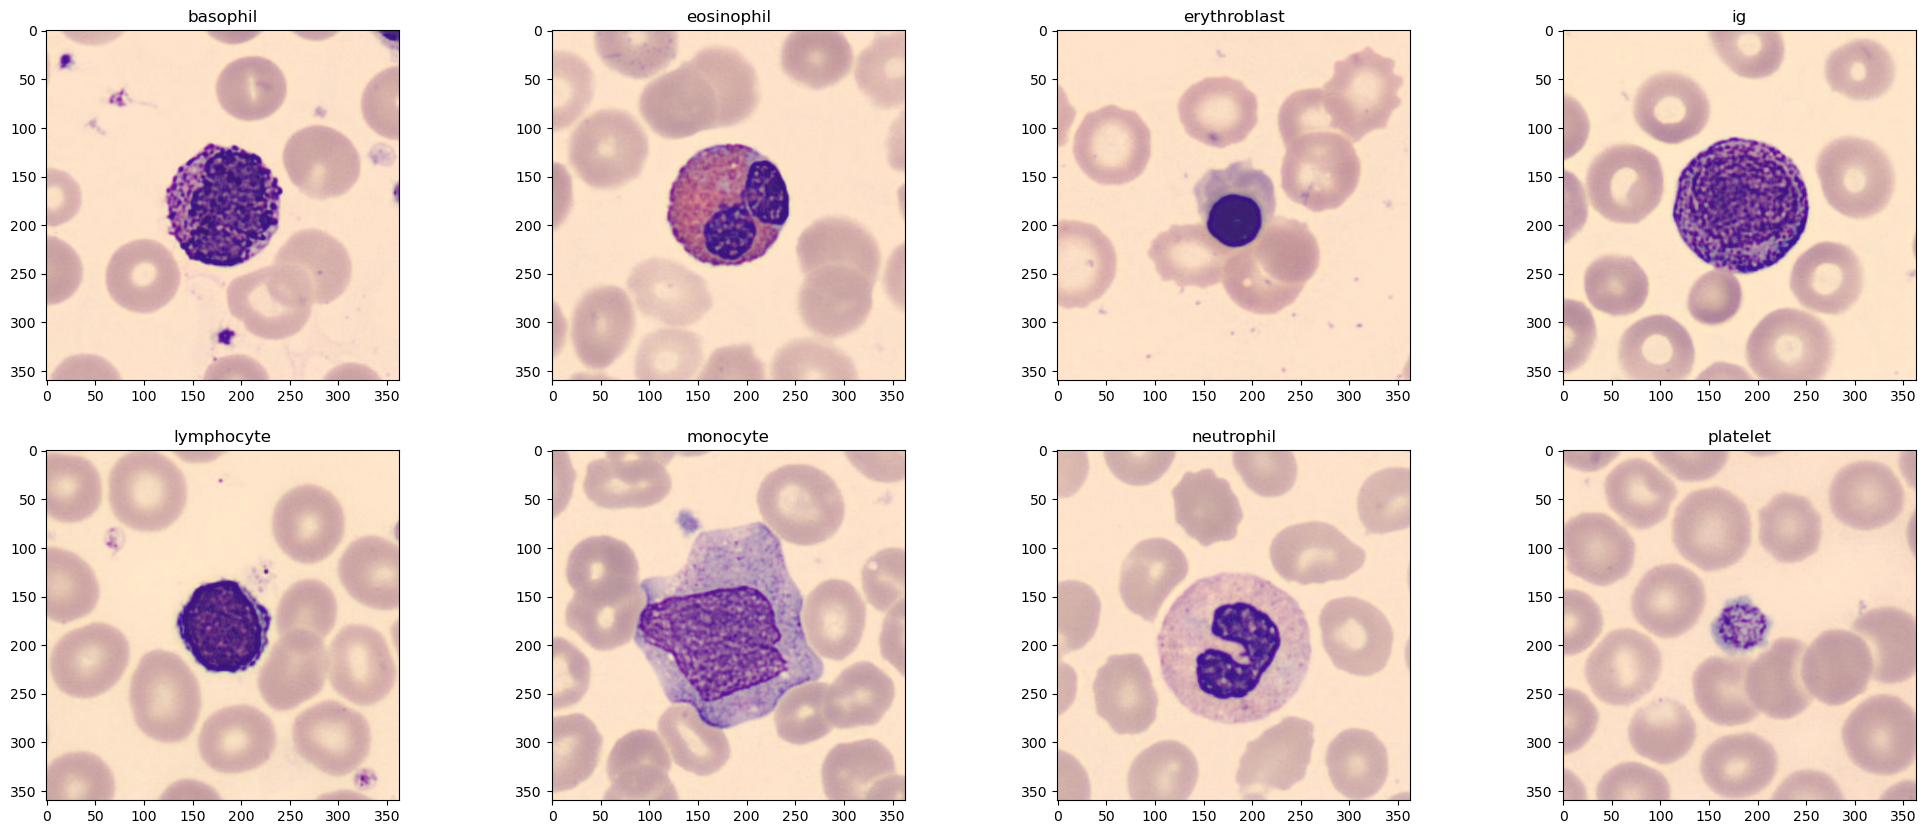

In [7]:
plot_random_by_classes(df)

Ce premier aperçu des classes de cellules met en évidence plusieurs différences caractéristiques :

- la taille des cellules
- la forme des cellules
- la taille du noyau
- la forme du noyau

A première vue, on peut remarquer des similitudes entre certains types de cellules par la forme de leur noyau, la coloration ou leur taille.

Des éléments peuvent venir parasiter l'information importante :

- Il y a des globules rouges en fond, dont le nombre et l'aspect peuvent différer fortement d'une image à l'autre, et on constate la possibilité d'avoir plusieurs cellules colorées sur une même image.

Les images sont au format RGB : elles sont toutes de même taille (redimensionnées 363x360).
Les images venant d'une même source, les luminosités et teintes de celles-ci paraissent similaires.

## Projection UMAP 3D

In [24]:
# Création d'un Dataframe réduit
df_baso = df[(df['classes']=='basophil')].sample(100)
df_eo = df[(df['classes']=='eosinophil')].sample(100)
df_ery = df[(df['classes']=='erythroblast')].sample(100)
df_ig = df[(df['classes']=='ig')].sample(100)
df_lym = df[(df['classes']=='lymphocyte')].sample(100)
df_mono = df[(df['classes']=='monocyte')].sample(100)
df_neu = df[(df['classes']=='neutrophil')].sample(100)
df_plat = df[(df['classes']=='platelet')].sample(100)

In [25]:
df_mini = pd.concat([df_baso, df_eo, df_ery, df_ig, df_lym, df_mono, df_neu, df_plat])

In [36]:
# df_mini.to_csv('dataset_mini.csv')

In [26]:
df_mini.sample(30)

img_path       classes  \
4252   C:\Users\lebre\Documents\Jupyter Notebook\PyBl...    eosinophil   
14840  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...      platelet   
11125  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...      monocyte   
9715   C:\Users\lebre\Documents\Jupyter Notebook\PyBl...    lymphocyte   
11175  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...      monocyte   
6606   C:\Users\lebre\Documents\Jupyter Notebook\PyBl...            ig   
901    C:\Users\lebre\Documents\Jupyter Notebook\PyBl...      basophil   
4107   C:\Users\lebre\Documents\Jupyter Notebook\PyBl...    eosinophil   
5868   C:\Users\lebre\Documents\Jupyter Notebook\PyBl...  erythroblast   
6169   C:\Users\lebre\Documents\Jupyter Notebook\PyBl...            ig   
8418   C:\Users\lebre\Documents\Jupyter Notebook\PyBl...            ig   
9275   C:\Users\lebre\Documents\Jupyter Notebook\PyBl...    lymphocyte   
15237  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...      platelet   
1817   C:\Users\lebre\Documents\Jupyter Notebook\PyBl...    eosinophil   
3350   C:\Users\lebre\Documents\Jupyter Notebook\PyBl...    eosinophil   
14007  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...    neutrophil   
15263  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...      platelet   
15253  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...      platelet   
8618   C:\Users\lebre\Documents\Jupyter Notebook\PyBl...            ig   
3403   C:\Users\lebre\Documents\Jupyter Notebook\PyBl...    eosinophil   
937    C:\Users\lebre\Documents\Jupyter Notebook\PyBl...      basophil   
5129   C:\Users\lebre\Documents\Jupyter Notebook\PyBl...  erythroblast   
13545  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...    neutrophil   
10170  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...      monocyte   
1050   C:\Users\lebre\Documents\Jupyter Notebook\PyBl...      basophil   
10327  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...      monocyte   
13663  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...    neutrophil   
12985  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...    neutrophil   
10875  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...      monocyte   
16591  C:\Users\lebre\Documents\Jupyter Notebook\PyBl...      platelet   

      sub_classes  
4252           EO  
14840    PLATELET  
11125          MO  
9715           LY  
11175          MO  
6606          MMY  
901            BA  
4107           EO  
5868          ERB  
6169          MMY  
8418          PMY  
9275           LY  
15237    PLATELET  
1817           EO  
3350           EO  
14007         SNE  
15263    PLATELET  
15253    PLATELET  
8618          PMY  
3403           EO  
937            BA  
5129          ERB  
13545         SNE  
10170          MO  
1050           BA  
10327          MO  
13663         SNE  
12985         SNE  
10875          MO  
16591    PLATELET

In [27]:
# Chargement des images en nuances de gris
dfile_bag = bag.from_sequence(df_mini.img_path.to_list()).map(load_image, as_gray=True)
with diagnostics.ProgressBar():
    images = np.array(dfile_bag.compute())
images_flat = images.reshape(images.shape[0], -1)

[########################################] | 100% Completed | 3.21 ss


In [28]:
images_flat.shape

(800, 130680)

In [32]:
# Modèle UMAP

mapper = umap.UMAP(random_state=4, n_components=3, init='random').fit(images_flat)
embedding = mapper.transform(images_flat)

In [33]:
plot_df = pd.DataFrame(df_mini.classes)
plot_df['X_UMAP'] = embedding[:, 0]
plot_df['Y_UMAP'] = embedding[:, 1]
plot_df['Z_UMAP'] = embedding[:, 2]

In [35]:
# plot_df.to_csv('plot_UMAP.csv')

In [34]:
fig_3d = px.scatter_3d(data_frame = plot_df, x='X_UMAP', y='Y_UMAP', z='Z_UMAP', color=df_mini.classes, labels={'color': 'classes'})
fig_3d.update_traces(marker_size=5)
fig_3d.show()

On remarque que les plaquettes (PLATELET) et les érythroblastes dans une moindre mesure se détachent du reste des cellules qui sont regroupées de façon plus homogène. On peut donc s'attendre à ce que les modèles aient plus de facilité à prédire ces classes.

## Segmentation des images

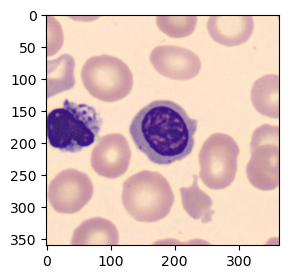

In [601]:
# Chargement et affichage d'une image aléatoire
rand_index = np.random.choice(range(df.shape[0]))
img = load_image(df.img_path[rand_index])
plt.figure(figsize=(3,3))
plt.imshow(img);

In [602]:
# Segmentation de l'image par couleur
img_gray = (img[:,:,0]+img[:,:,2])/(2*img[:,:,1])  # (R+G)/(2*B) -> Pour faire ressortir la cellule qui
                                                                    # a une couleur plus bleutée/violacée
img_gray2 = img_gray.copy()
for i in range(img_gray2.shape[0]):
    for j in range(img_gray2.shape[1]):
            if img_gray[i][j]<5:    # Si valeur pixel < 5, prend la valeur 0
                img_gray2[i,j]=0

# Seuillage de l'image
ret, thresh = cv2.threshold(img_gray2.astype(np.uint8),0,255,cv2.THRESH_BINARY_INV)  # Seuillage (Thresholding)
# Réduction du bruit par ouverture
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 15) # Ouverture (Opening -> erosion + dilatation)

C:\Users\lebre\AppData\Local\Temp\ipykernel_14928\38968207.py:2: RuntimeWarning: divide by zero encountered in true_divide
  img_gray = (img[:,:,0]+img[:,:,2])/(2*img[:,:,1])  # (R+G)/(2*B) -> Pour faire ressortir la cellule qui


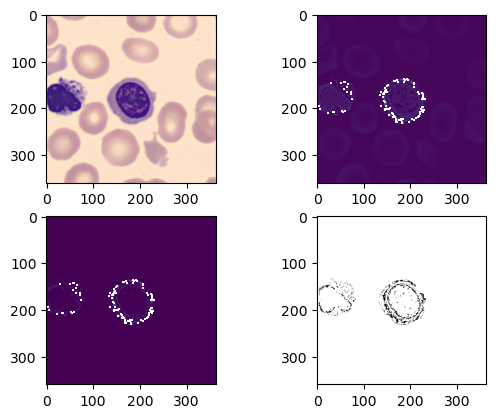

In [609]:
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(img_gray)
plt.subplot(223)
plt.imshow(img_gray2)
plt.subplot(224)
plt.imshow(thresh, 'gray');

In [604]:
# Zone de background sûre
sure_bg = cv2.dilate(opening, kernel, iterations=10) # Dilatation

cell_mask = cv2.bitwise_not(sure_bg) # Inversion des pixels
    
contour,hier = cv2.findContours(cell_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE) # Recherche des contours de la cellule
for cnt in contour:
    cv2.drawContours(cell_mask,[cnt],0,255,-1) # Dessin des contours de la cellule

sure_bg = cv2.bitwise_not(cell_mask) # Inversion des pixels

img_gray3 = np.ones(sure_bg.shape)*255 # Matrice de pixels blancs    
ret, thresh2 = cv2.threshold(sure_bg, 127, 255, 0) # Seuillage du background (élimination du bruit)
    
contours, hierarchy = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Recherche des contours du background

image = cv2.drawContours(img_gray3, contours, -1, (0, 255, 0), 1) # Dessin des contours du background

img_gray4 = np.ones(sure_bg.shape)*255 # Matrice de pixels blancs

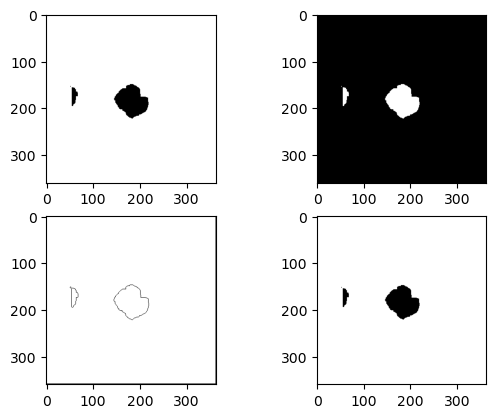

In [622]:
plt.subplot(221)
plt.imshow(sure_bg, 'gray')
plt.subplot(222)
plt.imshow(cell_mask, 'gray')
plt.subplot(223)
plt.imshow(img_gray3, 'gray')
plt.subplot(224)
plt.imshow(thresh2, 'gray');

In [612]:
# Recherche du contour central
m=[]
for ip in range(len(contours)):
    x=[contours[ip][:,:,0].mean(),contours[ip][:,:,1].mean()]
    m.append(np.sqrt((x[0]-sure_bg.shape[0]/2)**2+ (x[0]-sure_bg.shape[0]/2)**2))
        
if len(m)>1:    # Si len(m) > 1, il s'agit du contour central
    m=m[1:]
    contour_center=contours[np.argmin(m)+1]

    image2=cv2.drawContours(img_gray4, [contour_center], -1, (0, 255, 0), 1) # Dessin du contour central
    dist_transform = cv2.distanceTransform(image2.astype(np.uint8), cv2.DIST_L2,5) # Algorithme de distanceTransform

    ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0) # Masque du foreground (premier plan) agrandi
    sure_fg = scipy.ndimage.binary_fill_holes(255-sure_fg).astype(int) # Remplissage des trous éventuels
    img_seg = img.copy()                 
    for k in [0,1,2]:
        for i in range(img_seg.shape[0]):
            for j in range(img_seg.shape[1]):
                if sure_fg [i,j]==0 :  # Si le pixel est dans le background
                    img_seg[i,j,k]=0  # Il prend la valeur 0
    
    
elif len(m)==1:    # Si len(m) = 1, il ne s'agit pas du contour central
    contour_center=contours[np.argmin(m)]

    image2=cv2.drawContours(img_gray4, [contour_center], -1, (0, 255, 0), 1) # Dessin du contour central
    dist_transform = cv2.distanceTransform(image2.astype(np.uint8), cv2.DIST_L2,5) # Algorithme de distanceTransform

    ret, sure_fg = cv2.threshold(dist_transform,0.01*dist_transform.max(),255,0) # Masque du foreground (premier plan) agrandi
    sure_fg = scipy.ndimage.binary_fill_holes(255-sure_fg).astype(int) # Remplissage des trous éventuels
    img_seg = img.copy()                 
    for k in [0,1,2]:
        for i in range(img_seg.shape[0]):
            for j in range(img_seg.shape[1]):
                if sure_fg [i,j]!=0 :  # Si le pixel n'est pas dans le background
                    img_seg[i,j,k]=0  # Il prend la valeur 0

else:
    img_seg = img

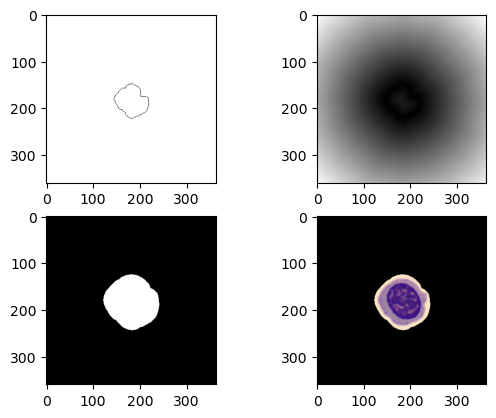

In [623]:
plt.subplot(221)
plt.imshow(image2, 'gray')
plt.subplot(222)
plt.imshow(dist_transform, 'gray')
plt.subplot(223)
plt.imshow(sure_fg, 'gray')
plt.subplot(224)
plt.imshow(img_seg);